Import der benötigten Module. Das Modul "ecgdetectors" wird zuerst heruntergeladen und installiert.

In [ ]:
pip install keras-tuner


In [6]:
from google.colab import files
import csv
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.preprocessing import normalize
from keras.utils import np_utils
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow as tf
import keras_tuner as kt
from sklearn.utils import class_weight
import seaborn as sns
import os
import tempfile
nb_classes = 2

Upload-Dialog, um die EKG-Daten in die virtuelle Maschine zu laden und zu entpacken (es erfolgt keine Prüfung, ob die richtige Datei hochgeladen wurde)

In [ ]:
uploaded = files.upload()
!unzip training.zip

Alternative: direkter Download aus Google Drive (deutlich schneller)

In [7]:
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/My Drive/training.zip" .
!unzip training.zip

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: training/train_ecg_01001.mat  
  inflating: training/train_ecg_01002.mat  
  inflating: training/train_ecg_01003.mat  
  inflating: training/train_ecg_01004.mat  
  inflating: training/train_ecg_01005.mat  
  inflating: training/train_ecg_01006.mat  
  inflating: training/train_ecg_01007.mat  
  inflating: training/train_ecg_01008.mat  
  inflating: training/train_ecg_01009.mat  
  inflating: training/train_ecg_01010.mat  
  inflating: training/train_ecg_01011.mat  
  inflating: training/train_ecg_01012.mat  
  inflating: training/train_ecg_01013.mat  
  inflating: training/train_ecg_01014.mat  
  inflating: training/train_ecg_01015.mat  
  inflating: training/train_ecg_01016.mat  
  inflating: training/train_ecg_01017.mat  
  inflating: training/train_ecg_01018.mat  
  inflating: training/train_ecg_01019.mat  
  inflating: training/train_ecg_01020.mat  
  inflating: training/train_ecg_01021.mat  
  inflati

In [8]:
def data_preprocessing(ecg_lead,zero_mean_loop):
  if zero_mean_loop ==2:# repeat array to fill 
        if ecg_lead.size<9000: 
          ecg_array_processed = np.array([])
          ecg_array_processed_part2 = np.zeros((9000,), dtype=int)
          #data gets looped till it has size of atleast 9000
          repetitions,remainder=divmod(9000,ecg_lead.size)
          repetitions+=1 
          for x in range(repetitions): 
            ecg_array_processed=np.concatenate((ecg_array_processed,ecg_lead))
          return ecg_array_processed[0:9000],ecg_array_processed_part2[0:9000]      
        if ecg_lead.size>9000:
          #first 9000 can be used unaltered
          ecg_array_processed=ecg_lead[0:9000]
          ecg_array_processed_part2 = np.array([])
          #data above 9000 gets looped till it has size of atleast 9000
          repetitions,remainder=divmod(9000,ecg_lead.size-9000)
          repetitions+=1 
          for x in range(repetitions): 
            ecg_array_processed_part2=np.concatenate((ecg_array_processed_part2,ecg_lead[9000:ecg_lead.size]))
          return ecg_array_processed[0:9000],ecg_array_processed_part2[0:9000]
        if ecg_lead.size==9000:
          ecg_array_processed=ecg_lead[0:9000]
          ecg_array_processed_part2 = np.zeros((9000,), dtype=int)
          return ecg_array_processed,ecg_array_processed_part2[0:9000]
  else: # zero or mean fill of array
        if zero_mean_loop == 0:
          ecg_array_processed = np.zeros((9000,), dtype=int)
          ecg_array_processed_part2 = np.zeros((10000,), dtype=int)
        if zero_mean_loop ==1:
          ecg_mean=np.mean(ecg_lead)   
          ecg_array_processed = np.empty([9000,])
          ecg_array_processed_part2 = np.empty([10000,])
          ecg_array_processed.fill(ecg_mean)
          ecg_array_processed_part2.fill(ecg_mean)
        if ecg_lead.size<9000:      
          ecg_array_processed[0:ecg_lead.size]=ecg_lead[0:ecg_lead.size]
          return ecg_array_processed,ecg_array_processed_part2[0:9000]      
        if ecg_lead.size>9000:
          ecg_array_processed=ecg_lead[0:9000]
          ecg_array_processed_part2[0:ecg_lead.size-9000]=ecg_lead[9000:ecg_lead.size]
          return ecg_array_processed,ecg_array_processed_part2[0:9000]
        if ecg_lead.size==9000:
          ecg_array_processed=ecg_lead[0:9000]
          return ecg_array_processed,ecg_array_processed_part2[0:9000]

In [9]:
sdnn_normal = np.array([])                                # Initialisierung der Feature-Arrays
sdnn_afib = np.array([])
ecg_class = np.array([])
with open('training/REFERENCE.csv') as csv_file:      # Einlesen der Liste mit Dateinamen und Zuordnung
    csv_reader = csv.reader(csv_file, delimiter=',')
    normal_line_count = 0
    afib_line_count = 0
    for row in csv_reader:
      data = sio.loadmat('training/'+row[0]+'.mat')   # Import der EKG-Dateien
      ecg_lead = data['val'][0]
      ecg_array_processed,ecg_array_processed_part2 = data_preprocessing(ecg_lead,2) #data preprocessing 0=fill with zero 1=fill with mean 2=loop
      if row[1] != 'A':                                                   # includes N,O,~
        if normal_line_count != 0:                                        #check if its the first time so that vstack can work properly
          sdnn_normal = np.vstack((sdnn_normal,ecg_array_processed)) 
          if ecg_lead.size>9000:
            sdnn_normal = np.vstack((sdnn_normal,ecg_array_processed_part2))       
        else:
          sdnn_normal=ecg_array_processed
          if ecg_lead.size>9000:
            sdnn_normal = np.vstack((sdnn_normal,ecg_array_processed_part2)) 
        normal_line_count = normal_line_count + 1    
      if row[1]=='A':                                                     # Zuordnung zu "Vorhofflimmern"          
        if afib_line_count != 0:                                          #check if its the first time so that vstack can work properly
          sdnn_afib = np.vstack((sdnn_afib,ecg_array_processed))
          if ecg_lead.size>9000:
            sdnn_afib = np.vstack((sdnn_afib,ecg_array_processed_part2))        
        else:
          sdnn_afib=ecg_array_processed
          if ecg_lead.size>9000:
            sdnn_afib = np.vstack((sdnn_afib,ecg_array_processed_part2))                                 
        afib_line_count = afib_line_count + 1

    if (normal_line_count+ afib_line_count % 100)==0:
        print(str(normal_line_count+ afib_line_count) + "\t Dateien wurden verarbeitet.")

In [10]:
#split data for testing and training
X_train_normal, X_test_normal = train_test_split(sdnn_normal, test_size=0.2, random_state=4)
X_train_afib, X_test_afib = train_test_split(sdnn_afib, test_size=0.2, random_state=4)

#balance the training dataset without getting test data into the training data 
ids = np.arange(len(X_train_afib))
choices = np.random.choice(ids, len(X_train_normal))
X_train_afib_balanced = X_train_afib[choices]

#train class
normal_class_train=np.zeros(X_train_normal.shape[0])       
normal_class_train.fill(0)
afib_class_train=np.zeros(X_train_afib_balanced.shape[0])
afib_class_train.fill(1)
#test class
normal_class_test=np.zeros(X_test_normal.shape[0])       
normal_class_test.fill(0)
afib_class_test=np.zeros(X_test_afib.shape[0])
afib_class_test.fill(1)

#combine train and test set
X_train=np.concatenate((X_train_normal, X_train_afib_balanced))
y_train=np.concatenate((normal_class_train, afib_class_train))

X_val=np.concatenate((X_test_normal, X_test_afib))
y_val=np.concatenate((normal_class_test, afib_class_test))

#shuffle train 
order = np.arange(len(X_train))
np.random.shuffle(order)
X_train = X_train[order]
y_train = y_train[order]
#shuffle test
order = np.arange(len(X_val))
np.random.shuffle(order)
X_val = X_val[order]
y_val = y_val[order]
#convert for NN
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_val = np_utils.to_categorical(y_val, nb_classes)


In [ ]:
#clip to get rid of outliers
X_train = np.clip(X_train, -500, 500)
X_val = np.clip(X_val, -500, 500)
#standardize the data
std_slc = StandardScaler()
std_slc.fit(X_train)
X_train_std = std_slc.transform(X_train)
X_val_std = std_slc.transform(X_val)
#save slc for predictions
pickle.dump(std_slc, open('/content/drive/My Drive/scaler.pkl','wb'))

print('Training labels shape:', Y_train.shape)
print('Validation labels shape:', Y_val.shape)
#print('Test labels shape:', test_labels.shape)

print('Training features shape:', X_train_std.shape)
print('Validation features shape:', X_val_std.shape)
#print('Test features shape:', test_features.shape)



print('max value:',np.amax(X_train_std))
print('mean value:',np.mean(X_train_std))
print('min value:',np.amin(X_train_std))


#calculate the class imbalance
sum_class1=Y_train[0:Y_train.shape[0],0]==1
sum_class2=Y_train[0:Y_train.shape[0],1]==1
sum_class1=sum_class1.sum()
sum_class2=sum_class2.sum()
total=sum_class1+sum_class2
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, sum_class2, 100 * sum_class2 / total))

   
weight_for_0 = (1 / sum_class1) * (total / 2.0)
weight_for_1 = (1 / sum_class2) * (total / 2.0)

class_weight = {0: weight_for_0,
                1: weight_for_1
                }

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))




In [15]:
sc = pickle.load(open('/content/drive/My Drive/scaler.pkl','rb'))
X_train_std = sc.transform(X_train)

Hypermodel

In [36]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      keras.metrics.BinaryAccuracy(name='binary_accuracy')
]
def model_builder(hp):
  # Initialize the Sequential API and start stacking the layers
  model = keras.Sequential()
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units_first', min_value=320, max_value=512, step=)
  hp_reg = hp.Choice('reg_first', values=[1e-2, 1e-3, 1e-4])
  model.add(keras.layers.Dense(units=hp_units, activation='relu',kernel_regularizer=regularizers.l2(hp_reg), name='dense_first', input_shape=[9000]))

  model.add(layers.BatchNormalization())

  hp_drop = hp.Float('dropout_first', min_value=0.0, max_value=0.7, step=0.1)
  model.add(keras.layers.Dropout(hp_drop))

  # #second dense layer
  # hp_units_2 = hp.Int('units_2', min_value=320, max_value=512, step=32)
  # hp_reg_2 = hp.Choice('reg_2', values=[1e-2, 1e-3, 1e-4])
  # model.add(keras.layers.Dense(units=hp_units_2, activation='relu',kernel_regularizer=regularizers.l2(hp_reg_2), name='dense_2'))

  # model.add(layers.BatchNormalization())

  # hp_drop_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.7, step=0.1)
  # model.add(keras.layers.Dropout(hp_drop_2))

  # #third dense layer
  # hp_units_3 = hp.Int('units_3', min_value=320, max_value=512, step=32)
  # hp_reg_3 = hp.Choice('reg_3', values=[1e-2, 1e-3, 1e-4])
  # model.add(keras.layers.Dense(units=hp_units_2, activation='relu',kernel_regularizer=regularizers.l2(hp_reg_2), name='dense_3'))

  # model.add(layers.BatchNormalization())

  # hp_drop_3 = hp.Float('dropout_3', min_value=0.1, max_value=0.7, step=0.1)
  # model.add(keras.layers.Dropout(hp_drop_3))
  # ##dense layer
  # hp_units_3 = hp.Int('units_3', min_value=32, max_value=512, step=32)
  # model.add(keras.layers.Dense(units=hp_units_3, activation='relu', name='dense_3'))
  # hp_drop_3 = hp.Float('dropout_3', min_value=0.1, max_value=0.7, step=0.1)
  # model.add(keras.layers.Dropout(hp_drop_3))
  # model.add(layers.BatchNormalization())

  # for i in range(hp.Int('layers', 2, 6)):
  #     model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i), 32, 512, step=32),
  #                                   activation='relu'))
  #     model.add(keras.layers.Dropout(hp.Float('dropout_'+ str(i), min_value=0.0, max_value=0.5, step=0.1)))
  #     model.add(layers.BatchNormalization())

  model.add(keras.layers.Dense(2, activation='sigmoid'))
  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='binary_crossentropy',
                metrics=METRICS)
  return model

# Instantiate the tuner
#tuner.objective("prc", direction="max")
tuner = kt.Hyperband(model_builder, # the hypermodel
                     objective=kt.Objective('val_loss', direction='min'),
                     max_epochs=20,
                     factor=3, # factor which you have seen above 
                     directory='dir', # directory to save logs 
                     project_name='khyperband'
                     )
tuner.overwrite=True
# hypertuning settings
tuner.search_space_summary() 

Search space summary
Default search space size: 10
units_first (Int)
{'default': None, 'conditions': [], 'min_value': 320, 'max_value': 512, 'step': 32, 'sampling': None}
reg_first (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dropout_first (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.7, 'step': 0.1, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 320, 'max_value': 512, 'step': 32, 'sampling': None}
reg_2 (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dropout_2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.7, 'step': 0.1, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 320, 'max_value': 512, 'step': 32, 'sampling': None}
reg_3 (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dropout_3 (Float)
{'default': 0.1, 'conditions

In [35]:
%rm -rf dir

In [37]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Perform hypertuning
tuner.search(X_train_std, Y_train, epochs=50, validation_data=(X_val_std, Y_val), callbacks=[stop_early]
             #,class_weight=class_weight
             )
tuner.results_summary()

Trial 30 Complete [00h 05m 36s]
val_loss: 0.8410329222679138

Best val_loss So Far: 0.7188240885734558
Total elapsed time: 01h 05m 01s
Results summary
Results in dir/khyperband
Showing 10 best trials
Trial summary
Hyperparameters:
units_first: 384
reg_first: 0.0001
dropout_first: 0.4
units_2: 480
reg_2: 0.0001
dropout_2: 0.1
units_3: 448
reg_3: 0.01
dropout_3: 0.4
learning_rate: 0.001
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0019
Score: 0.7188240885734558
Trial summary
Hyperparameters:
units_first: 384
reg_first: 0.0001
dropout_first: 0.4
units_2: 480
reg_2: 0.0001
dropout_2: 0.1
units_3: 448
reg_3: 0.01
dropout_3: 0.4
learning_rate: 0.001
tuner/epochs: 7
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.7376520037651062
Trial summary
Hyperparameters:
units_first: 384
reg_first: 0.0001
dropout_first: 0.30000000000000004
units_2: 384
reg_2: 0.01
dropout_2: 0.1
units_3: 320
reg_3: 0.0001
dropout_3: 0.30000000000000004
learning_

In [38]:
# Build the model with the optimal hyperparameters
best_hp=tuner.get_best_hyperparameters()[0]
#print(best_hp.get('units'))
h_model = tuner.hypermodel.build(best_hp)
h_model.summary()
history=h_model.fit(X_train_std, Y_train, epochs=20, validation_data=(X_val_std, Y_val)
                    #,class_weight=class_weight
                    )

# #determine best epoch
# val_acc_per_epoch = history.history['val_recall']
# best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
# print('Best epoch: %d' % (best_epoch,))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_first (Dense)         (None, 384)               3456384   
                                                                 
 batch_normalization_3 (Batc  (None, 384)              1536      
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 384)               0         
                                                                 
 dense_2 (Dense)             (None, 480)               184800    
                                                                 
 batch_normalization_4 (Batc  (None, 480)              1920      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 480)              

KeyboardInterrupt: ignored

In [ ]:
print(Y_val)
print(Y_val.argmax(axis=1))
test_predictions_baseline = h_model.predict(X_val_std,verbose=0)
print(test_predictions_baseline)
print(test_predictions_baseline.argmax(axis=1))

loss :  1.297047734260559
tp :  1314.0
fp :  127.0
tn :  1301.0
fn :  114.0
accuracy :  0.9156162738800049
precision :  0.9118667840957642
recall :  0.9201680421829224
auc :  0.9259017705917358
prc :  0.906484842300415
binary_accuracy :  0.9156162738800049

Normal ECG Detected (True Negatives):  5214
Normal ECG Incorrectly Detected (False Positives):  0
AFIB ECG Missed (False Negatives):  4
AFIB ECG Detected (True Positives):  490
Total ECG AFIB:  494
Best epoch: 3


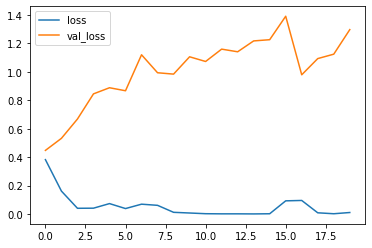

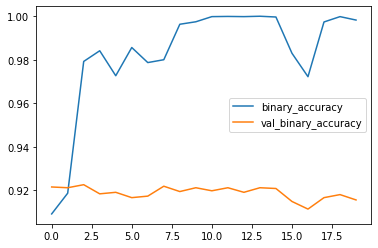

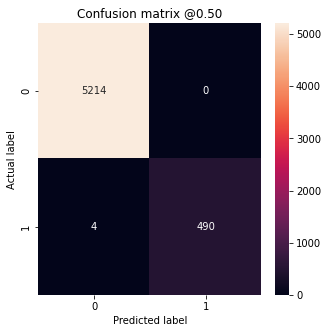

In [34]:
#plot loss
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

#Confusion Matrix
train_predictions_baseline = h_model.predict(X_train_std,verbose=0)
test_predictions_baseline = h_model.predict(X_val_std,verbose=0)

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Normal ECG Detected (True Negatives): ', cm[0][0])
  print('Normal ECG Incorrectly Detected (False Positives): ', cm[0][1])
  print('AFIB ECG Missed (False Negatives): ', cm[1][0])
  print('AFIB ECG Detected (True Positives): ', cm[1][1])
  print('Total ECG AFIB: ', np.sum(cm[1]))

baseline_results = h_model.evaluate(X_val_std, Y_val,verbose=0)
for name, value in zip(h_model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

#plot_cm(Y_val.argmax(axis=1), test_predictions_baseline.argmax(axis=1))

plot_cm(Y_train.argmax(axis=1), train_predictions_baseline.argmax(axis=1))

# #determine best epoch
val_acc_per_epoch = history.history['val_binary_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [33]:
# pretrained_base = tf.keras.models.load_model(
#     '../input/cv-course-models/cv-course-models/vgg16-pretrained-base',
# )
# pretrained_base.trainable = False


# model = keras.Sequential([
#     pretrained_base,
#     layers.Flatten(),
#     layers.Dense(6, activation='relu'),
#     layers.Dense(1, activation='sigmoid'),
# ])
##########Dense Model############
#set initial bias to reflect the class imbalance to speed up learning
#output_bias= None
#set intial Bias
# output_bias = np.log([sum_class2/sum_class1])
# output_bias = tf.keras.initializers.Constant(output_bias)

# model = keras.Sequential([
#     layers.Dense(25, activation='relu', input_shape=[9000]),
#     layers.Dropout(0.3),
#     layers.BatchNormalization(),
#     layers.Dense(25, activation='relu'),
#     layers.Dropout(0.3),
#     layers.BatchNormalization(),
#     layers.Dense(2, activation='sigmoid',bias_initializer=output_bias),
# ])
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      keras.metrics.BinaryAccuracy(name='binary_accuracy')
]
# def make_model(metrics=METRICS, output_bias=None):
#   if output_bias is not None:
#     output_bias = tf.keras.initializers.Constant(output_bias)
#   model = keras.Sequential([
#       layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),input_shape=(9000,)),
#       layers.BatchNormalization(),
#       layers.Dropout(0.5),
#       # layers.Dense(2048, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
#       # layers.BatchNormalization(),
#       # layers.Dropout(0.5),
#       # layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
#       # layers.BatchNormalization(),
#       # layers.Dropout(0.5),
#       # layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
#       # layers.BatchNormalization(),
#       # layers.Dropout(0.5),
#       # layers.Dense(192, activation='relu'),
#       # layers.BatchNormalization(),
#       # layers.Dropout(0.2),
#       # layers.Dense(320, activation='relu'),
#       # layers.BatchNormalization(),
#       # layers.Dropout(0.2),
#       # layers.Dense(32, activation='relu'),
#       # layers.BatchNormalization(),
#       # layers.Dropout(0.3),
#       layers.Dense(2, activation='sigmoid',
#                          #bias_initializer=output_bias
#                          ),
#   ])

#   model.compile(
#       optimizer=keras.optimizers.Adam(learning_rate=1e-3),
#       loss=keras.losses.BinaryCrossentropy(),
#       metrics=metrics)

#   return model
################CNN###################
def make_model(metrics=METRICS, output_bias=None):
  model = keras.Sequential([

      # First Convolutional Block
      layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.001),   #the filter size i chose is random in each layer so far
                    # give the input dimensions in the first layer
                    input_shape=[9000,1]),                                        #i am a little confused about input shape and if thats right
      layers.MaxPool1D(),#4500,16

      # Second Convolutional Block
      layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.001)),
      layers.BatchNormalization(),
      #layers.Dropout(0.5),
      layers.MaxPool1D(),#2250,32

      # Third Convolutional Block
      layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.001)),
      layers.BatchNormalization(),
      #layers.Dropout(0.5),
      layers.MaxPool1D(),#1125,64

      # Forth Convolutional Block
      layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.001)),
      layers.BatchNormalization(),
      #layers.Dropout(0.5),
      layers.MaxPool1D(),#563,64

      # Forth Convolutional Block
      layers.Conv1D(filters=8, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.001)),
      layers.BatchNormalization(),
      #layers.Dropout(0.5),
      layers.MaxPool1D(),#282,2

      # Forth Convolutional Block
      layers.Conv1D(filters=8, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.001)),
      layers.BatchNormalization(),
      #layers.Dropout(0.5),
      layers.MaxPool1D(),#141,2

      # Forth Convolutional Block
      layers.Conv1D(filters=4, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.001)),
      layers.BatchNormalization(),
      #layers.Dropout(0.5),
      layers.MaxPool1D(),#71,2
      # Forth Convolutional Block
      layers.Conv1D(filters=2, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.001)),
      layers.BatchNormalization(),
      #layers.Dropout(0.5),
      layers.MaxPool1D(),#71,2

      # Classifier Head
      layers.Flatten(),
      layers.Dense(32, activation='relu', input_shape=[70],kernel_regularizer=regularizers.l2(0.001)),                   #dense layer sizes could probably be chosen better
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.001)),    
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(2, activation='sigmoid'),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

##################Autoencoder#######################
# model = keras.Sequential([
#     #Encoder
#     # First Convolutional Block
#     layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same',   #9000,32
#                   input_shape=[9000,1]),                                        
#     layers.MaxPool1D(2,padding='same'),#4500,32
#     layers.BatchNormalization(),  
#     # Second Convolutional Block
#     layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same'),#4500,16
#     layers.MaxPool1D(2,padding='same'),#2250,16
#     layers.BatchNormalization(),  

#     # Third Convolutional Block
#     layers.Conv1D(filters=8, kernel_size=3, activation="relu", padding='same'),#2250,8
#     layers.MaxPool1D(2,padding='same'),#1125,8
#     layers.BatchNormalization(),  

#     #Decoder
#     layers.Conv1D(filters=8, kernel_size=3, activation="relu", padding='same'),#1125,8
#     layers.UpSampling1D(2),#2250,8
#     layers.BatchNormalization(),  

#     layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same'),#2250,16
#     layers.UpSampling1D(2),#4500,16
#     layers.BatchNormalization(),  

#     layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same'),#4500,32
#     layers.UpSampling1D(2),#9000,32
#     layers.BatchNormalization(),  

#     layers.Conv1D(filters=1, kernel_size=3, activation="relu", padding='same'),#9000,1
# ])


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_53 (Conv1D)          (None, 9000, 32)          128       
                                                                 
 max_pooling1d_53 (MaxPoolin  (None, 4500, 32)         0         
 g1D)                                                            
                                                                 
 conv1d_54 (Conv1D)          (None, 4500, 32)          3104      
                                                                 
 batch_normalization_62 (Bat  (None, 4500, 32)         128       
 chNormalization)                                                
                                                                 
 max_pooling1d_54 (MaxPoolin  (None, 2250, 32)         0         
 g1D)                                                            
                                                      

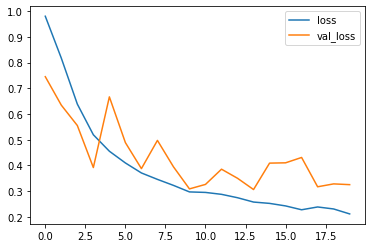

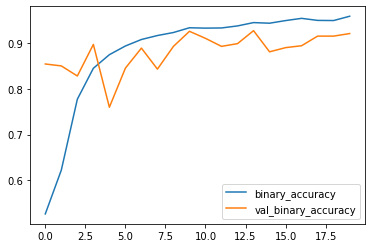

In [34]:
#####################Autoencoder#################################
# model.compile(
#     optimizer='adam',
#     loss='mean_squared_error',
#     metrics=['mean_absolute_percentage_error'],
# )

# history = model.fit(
#     X_train_std, X_train_std,
#     validation_data=(X_val_std, X_val_std),
#     epochs=30,
#     verbose=1,
# )

# history_frame = pd.DataFrame(history.history)
# history_frame.loc[:, ['loss', 'val_loss']].plot()
# history_frame.loc[:, ['mean_absolute_percentage_error', 'val_mean_absolute_percentage_error']].plot();

#################For CNN or Dense Model#########################
#show model architecture
# METRICS = [
#       keras.metrics.TruePositives(name='tp'),
#       keras.metrics.FalsePositives(name='fp'),
#       keras.metrics.TrueNegatives(name='tn'),
#       keras.metrics.FalseNegatives(name='fn'), 
#       keras.metrics.BinaryAccuracy(name='accuracy'),
#       keras.metrics.Precision(name='precision'),
#       keras.metrics.Recall(name='recall'),
#       keras.metrics.AUC(name='auc'),
#       keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
#       keras.metrics.BinaryAccuracy(name='binary_accuracy')
# ]

# model.compile(
#     optimizer='adam',
#     loss='binary_crossentropy',
#     metrics=METRICS,
# )
#set intial Bias to reflect unbalanced dataset
#initial_bias = np.log([sum_class2/sum_class1])

#load same weights for every model to make them comparable
model = make_model()
model.summary()
#early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=5, # number of epochs that didnt bring an improvement 
    mode='max',
    restore_best_weights=True)

history = model.fit(
    X_train_std, Y_train,
    validation_data=(X_val_std, Y_val),
    epochs=20,
    #callbacks=[early_stopping],
    #class_weight=class_weight,
    # batch_size=BATCH_SIZE,  
    verbose=1,
)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# def plot_loss(history, label, n):
#   # Use a log scale on y-axis to show the wide range of values.
#   plt.semilogy(history.epoch, history.history['loss'],
#                color=colors[n], label='Train ' + label)
#   plt.semilogy(history.epoch, history.history['val_loss'],
#                color=colors[n], label='Val ' + label,
#                linestyle="--")
#   plt.xlabel('Epoch')
#   plt.ylabel('Loss')
# plot_loss(history, "Zero Bias", 0)

# #determine best epoch
val_acc_per_epoch = history.history['val_binary_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

#plot loss
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

# # plot different metrics
# def plot_metrics(history):
#   metrics = ['loss', 'prc', 'precision', 'recall']
#   for n, metric in enumerate(metrics):
#     name = metric.replace("_"," ").capitalize()
#     plt.subplot(2,2,n+1)
#     plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
#     plt.plot(history.epoch, history.history['val_'+metric],
#              color=colors[0], linestyle="--", label='Val')
#     plt.xlabel('Epoch')
#     plt.ylabel(name)
#     if metric == 'loss':
#       plt.ylim([0, plt.ylim()[1]])
#     elif metric == 'auc':
#       plt.ylim([0.8,1])
#     else:
#       plt.ylim([0,1])
#     plt.legend()

# plot_metrics(history)    


Best epoch: 14


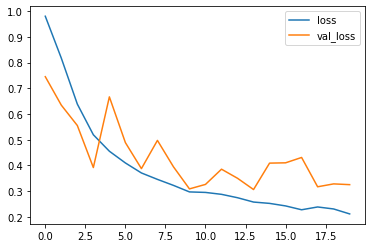

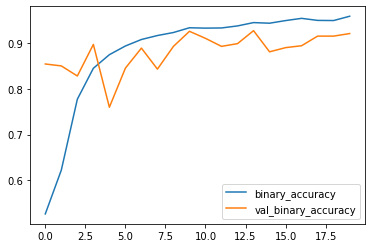

In [35]:
#plot loss
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

# #determine best epoch
val_acc_per_epoch = history.history['val_binary_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Confusion Matrix

loss :  0.32529330253601074
tp :  1315.0
fp :  113.0
tn :  1315.0
fn :  113.0
accuracy :  0.9208683371543884
precision :  0.9208683371543884
recall :  0.9208683371543884
auc :  0.9762935042381287
prc :  0.9748663902282715
binary_accuracy :  0.9208683371543884

Normal ECG Detected (True Negatives):  1295
Normal ECG Incorrectly Detected (False Positives):  11
AFIB ECG Missed (False Negatives):  117
AFIB ECG Detected (True Positives):  5
Total ECG AFIB:  122


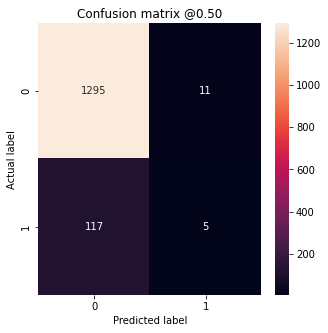

In [37]:
#train_predictions_baseline = model.predict(X_train_std,verbose=0)
test_predictions_baseline = model.predict(X_val,verbose=0)

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Normal ECG Detected (True Negatives): ', cm[0][0])
  print('Normal ECG Incorrectly Detected (False Positives): ', cm[0][1])
  print('AFIB ECG Missed (False Negatives): ', cm[1][0])
  print('AFIB ECG Detected (True Positives): ', cm[1][1])
  print('Total ECG AFIB: ', np.sum(cm[1]))

baseline_results = model.evaluate(X_val_std, Y_val,verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(Y_val.argmax(axis=1), test_predictions_baseline.argmax(axis=1))
#plot_cm(Y_train.argmax(axis=1), train_predictions_baseline.argmax(axis=1))

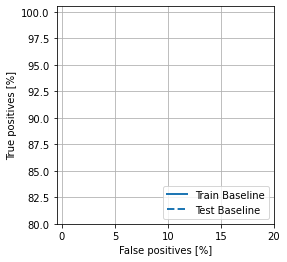

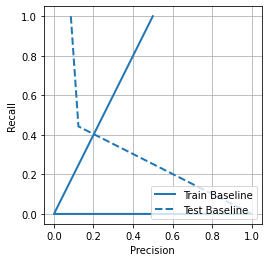

In [61]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
plot_roc("Train Baseline", Y_train.argmax(axis=1), train_predictions_baseline.argmax(axis=1), color=colors[0])
plot_roc("Test Baseline", Y_val.argmax(axis=1), test_predictions_baseline.argmax(axis=1), color=colors[0], linestyle='--')
plt.legend(loc='lower right');
plt.show()

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
plot_prc("Train Baseline", Y_train.argmax(axis=1), train_predictions_baseline.argmax(axis=1), color=colors[0])
plot_prc("Test Baseline", Y_val.argmax(axis=1), test_predictions_baseline.argmax(axis=1), color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [62]:
model.save('bad_CNN_model')